# Import libraries

In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
%matplotlib inline
plt.rcParams["axes.grid"] = False
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")


This case study is based on a Kaggle Competition conducted 7 months back based on a dataset by Aravind Eye Hospital in India to detect a form of Blindness called Diabetic Retinopathy. [https://www.kaggle.com/c/aptos2019-blindness-detection/overview](http://)  is the link to the Kaggle competition.

The goal here is to Build an Image Classification Model which can take a look at the images and classify the image into one of the 5 classes (0,1,2,3,4). This Image Classification Model can accelerate the process of Blindness Detection in Patients. Currently Doctors review the Image and classify it into one of the classes -

* 0 - No DR
* 1 - Mild
* 2 - Moderate
* 3 - Severe
* 4 - Proliferative DR <br>
Training data contains 3662 images, test data contains 1928 images

In [2]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
submission= pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [3]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show()

In [ ]:
plot_classes(train)

**Plot Summary - As we can see, there is class imbalance in the output class distribution. We shall account for this while training the models using data augmentation / class balancing methods**

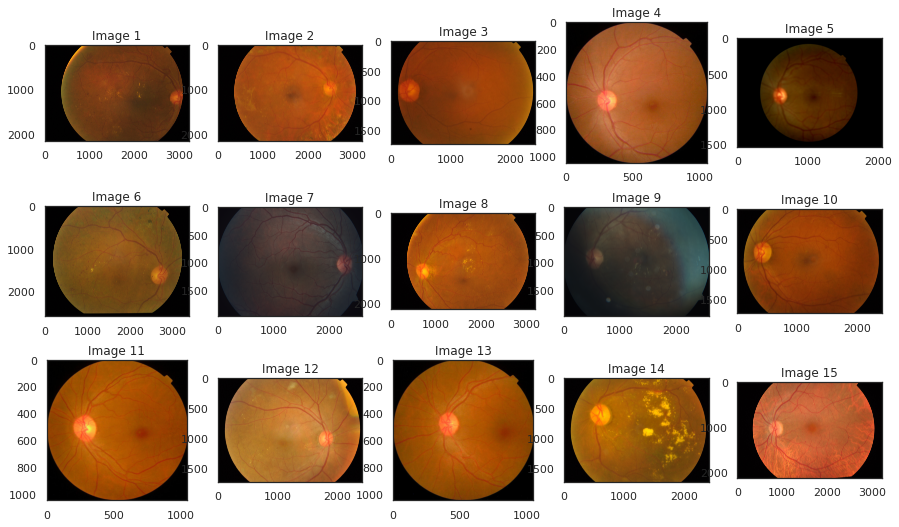

In [5]:
sns.set_style("white")
count = 1
plt.figure(figsize=[15, 15])
for img_name in train['id_code'][:15]:
    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [6]:
N_CLASSES = train['diagnosis'].nunique()
N_CLASSES

5

In [7]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [8]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')

Found 2930 validated image filenames belonging to 5 classes.


In [9]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation')

Found 732 validated image filenames belonging to 5 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


In [11]:
base_model = tf.keras.applications.ResNet152V2(input_shape=(224,224,3),include_top=False,weights="imagenet")

234553344/234545216 [==============================] - 3s 0us/step


In [12]:
#Freezing Layers

for layer in base_model.layers[:-10]:
    layer.trainable=False

In [13]:

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0

In [14]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [16]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.8, min_lr = 1e-6)

mcp = ModelCheckpoint('./ResNet152V2.h5')

es = EarlyStopping(verbose=1, patience=2)

In [17]:
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=METRICS)

In [18]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [19]:
%time
history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,epochs=10,callbacks=[lrd,mcp,es])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs
Epoch 1/10
183/183 [==============================] - 618s 3s/step - loss: 1.1175 - accuracy: 0.8526 - precision: 0.7539 - recall: 0.3694 - auc: 0.8313 - f1_score: 0.4760 - val_loss: 1.0780 - val_accuracy: 0.8725 - val_precision: 0.6992 - val_recall: 0.6361 - val_auc: 0.9024 - val_f1_score: 0.6653
Epoch 2/10
183/183 [==============================] - 488s 3s/step - loss: 0.7903 - accuracy: 0.8939 - precision: 0.8226 - recall: 0.5985 - auc: 0.9213 - f1_score: 0.6891 - val_loss: 0.8021 - val_accuracy: 0.8911 - val_precision: 0.7611 - val_recall: 0.6639 - val_auc: 0.9270 - val_f1_score: 0.7079
Epoch 3/10
183/183 [==============================] - 434s 2s/step - loss: 0.7481 - accuracy: 0.8970 - precision: 0.8209 - recall: 0.6204 - auc: 0.9294 - f1_score: 0.7042 - val_loss: 0.7270 - val_accuracy: 0.8967 - val_precision: 0.8222 - val_recall: 0.6167 - val_auc: 0.9349 - val_f1_score: 0.6995
Epoch 4/10
183/183 [===============

In [21]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 3662 validated image filenames.


In [22]:
STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

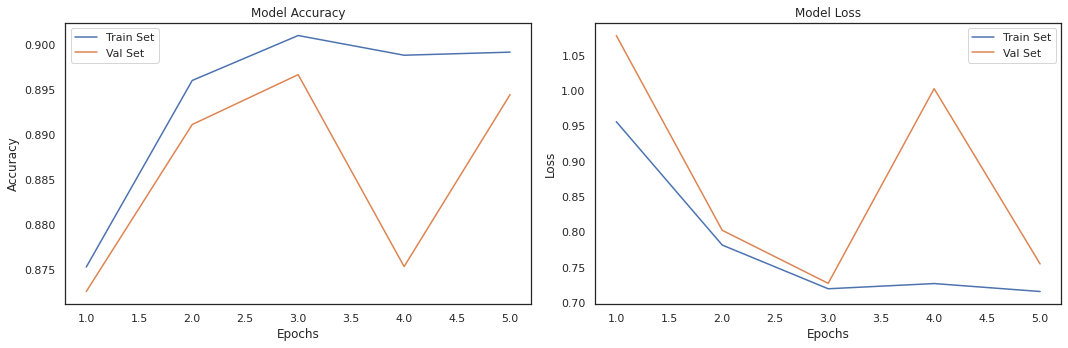

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

                      count      mean       std       min       25%       50%  \
0 - No DR               5.0  0.247762  0.414582  0.010363  0.030508  0.061061   
1 - Mild                5.0  0.171672  0.218180  0.013850  0.041451  0.116116   
2 - Moderate            5.0  0.407844  0.278825  0.003324  0.262162  0.466321   
3 - Severe              5.0  0.172721  0.192103  0.000000  0.032432  0.139139   
4 - Proliferative DR    5.0  0.000000  0.000000  0.000000  0.000000  0.000000   

                           75%       max  
0 - No DR             0.154054  0.982825  
1 - Mild              0.135593  0.551351  
2 - Moderate          0.623729  0.683684  
3 - Severe            0.210169  0.481865  
4 - Proliferative DR  0.000000  0.000000  


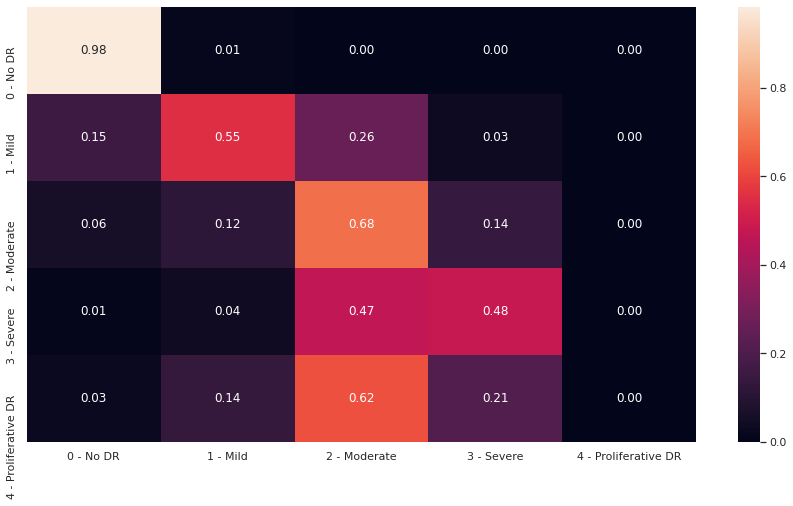

In [24]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
print(df_cm.describe().T)
plt.figure(figsize=(15, 8))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.show()

In [25]:
df_cm.head(5)

,0 - No DR,1 - Mild,2 - Moderate,3 - Severe,4 - Proliferative DR
0 - No DR,0.982825,0.013850,0.003324,0.000000,0.0
1 - Mild,0.154054,0.551351,0.262162,0.032432,0.0
2 - Moderate,0.061061,0.116116,0.683684,0.139139,0.0
3 - Severe,0.010363,0.041451,0.466321,0.481865,0.0
4 - Proliferative DR,0.030508,0.135593,0.623729,0.210169,0.0


In [26]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.791


In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title     A   = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

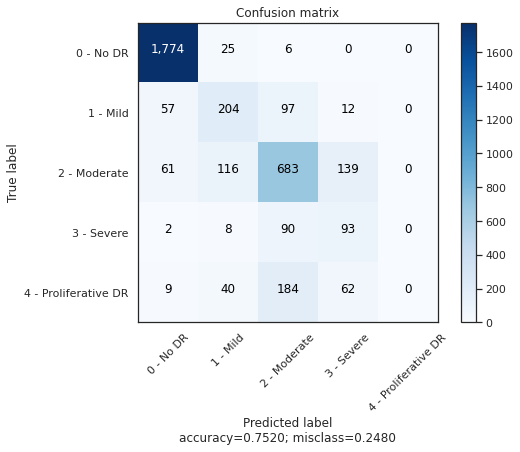

In [28]:
confusion_mtx = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)
#plot_confusion_matrix(actual,test_labels,labels)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(train['diagnosis'].astype('int'), train_preds))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1805
           1       0.52      0.55      0.53       370
           2       0.64      0.68      0.66       999
           3       0.30      0.48      0.37       193
           4       0.00      0.00      0.00       295

    accuracy                           0.75      3662
   macro avg       0.48      0.54      0.51      3662
weighted avg       0.70      0.75      0.73      3662



In [31]:
valid_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(valid_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

120/120 [==============================] - 95s 754ms/step


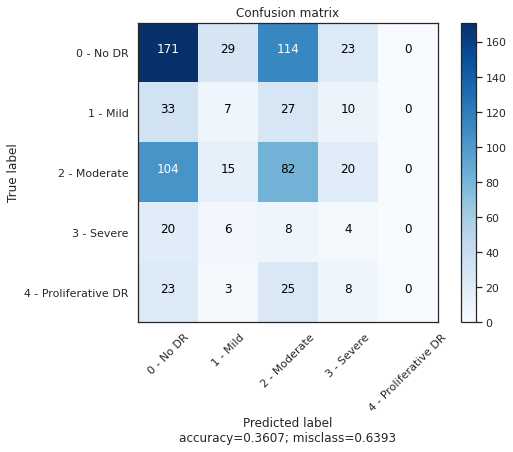

In [32]:
actual = valid_generator.classes
confusion_mtx = confusion_matrix(actual, test_labels)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)
#plot_confusion_matrix(actual,test_labels,labels)

In [35]:
testing_datagen = ImageDataGenerator(rescale=1./255)

testing_generator = testing_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images",
        x_col="id_code",
        y_col = "diagnosis",
        target_size=(224, 224),
        batch_size=1,
        shuffle=False,
        class_mode='categorical')

Found 3662 validated image filenames belonging to 5 classes.


In [36]:
pred = model.predict(testing_generator, steps = testing_generator.n//testing_generator.batch_size, verbose = 1)
predx = np.argmax(pred, axis=1)
actual =  testing_generator.classes

3662/3662 [==============================] - 464s 127ms/step


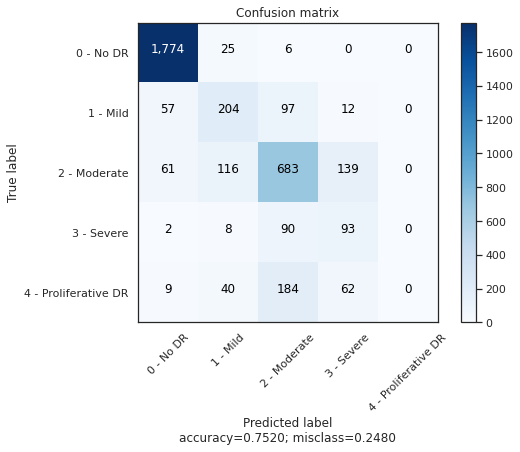

In [37]:
confusion_mtx = confusion_matrix(actual, predx)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

In [39]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]
predictions[:10]

[2, 2, 2, 2, 3, 2, 2, 0, 2, 2]

In [40]:
filenames = test_generator.filenames
results = pd.DataFrame(['id_code',filenames, 'diagnosis',predictions])
results.to_csv('submission.csv',index=False)
results.head(5).T

,0,1,2,3
0,id_code,"[0005cfc8afb6.png, 003f0afdcd15.png, 006efc72b...",diagnosis,"[2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, ..."


# Fine Tune ResNet50 Model

In [56]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [57]:
base_model2 = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(224,224,3)
)

In [58]:
for i, layer in enumerate(base_model2.layers):
    print(i, layer.name)

0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [59]:
model2=Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(256,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(5,activation='softmax'))

In [60]:
# Freezing Layers

for layer in base_model2.layers[:-10]:
    layer.trainable=False

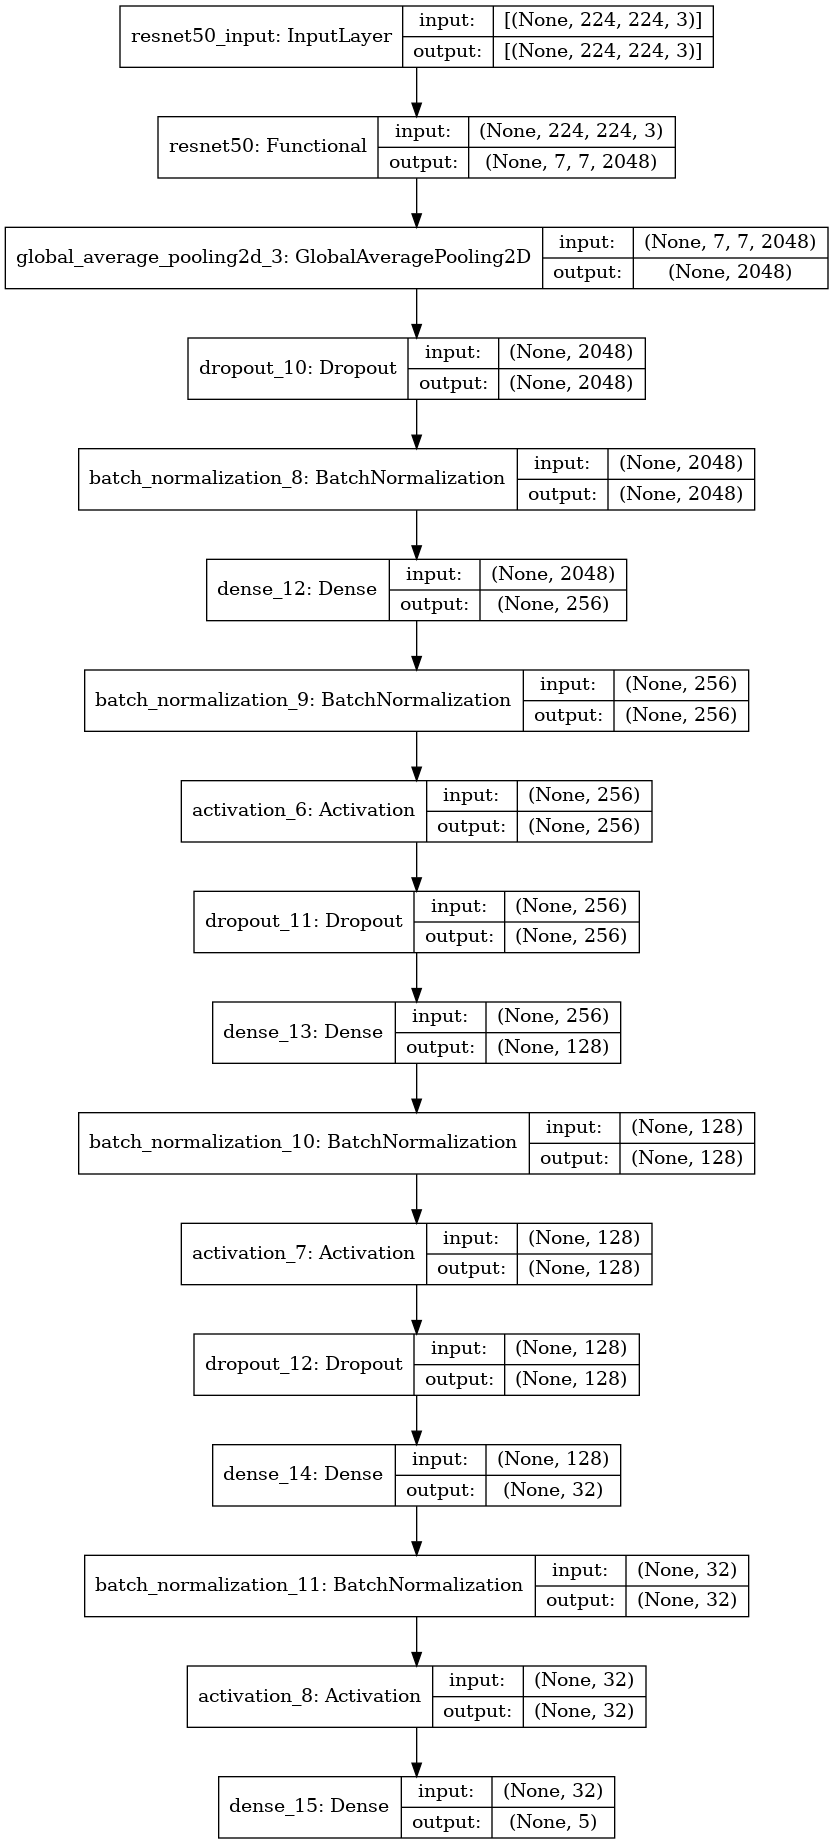

In [61]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model2, to_file='ResNet50.png', show_shapes=True,show_layer_names=True)
Image(filename='ResNet50.png')

In [62]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [63]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.SensitivityAtSpecificity(0.5,name = 'Sensitivity'),
        f1_score,
]

In [64]:
from keras.callbacks import ModelCheckpoint
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.8, min_lr = 1e-6)
saved_model = './ResNet50.h5'
mcp =  ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#mcp = ModelCheckpoint('ResNet152V2.h5')


In [65]:
model2.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=METRICS)

In [66]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [67]:
%time
history = model2.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,epochs=25,callbacks=[lrd,mcp])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
Epoch 1/25
183/183 [==============================] - 418s 2s/step - loss: 1.7154 - accuracy: 0.7836 - precision: 0.3675 - recall: 0.1172 - auc: 0.6149 - Sensitivity: 0.6564 - f1_score: 0.1756 - val_loss: 2.1543 - val_accuracy: 0.7850 - val_precision: 0.4625 - val_recall: 0.4625 - val_auc: 0.8230 - val_Sensitivity: 0.8944 - val_f1_score: 0.4625

Epoch 00001: val_accuracy improved from -inf to 0.78500, saving model to ./ResNet50.h5
Epoch 2/25
183/183 [==============================] - 403s 2s/step - loss: 0.9903 - accuracy: 0.8726 - precision: 0.7977 - recall: 0.4871 - auc: 0.8712 - Sensitivity: 0.9166 - f1_score: 0.6032 - val_loss: 2.3646 - val_accuracy: 0.7183 - val_precision: 0.2958 - val_recall: 0.2958 - val_auc: 0.4413 - val_Sensitivity: 0.3764 - val_f1_score: 0.2958

Epoch 00002: val_accuracy did not improve from 0.78500
Epoch 3/25
183/183 [==============================] - 406s 2s/step - loss: 0.8694 - accuracy: 0.885

In [69]:
model2.save('./myModel.h5')

In [68]:
from keras.models import load_model
savedModel = load_model('./ResNet50.h5')

ValueError: Unknown metric function: f1_score

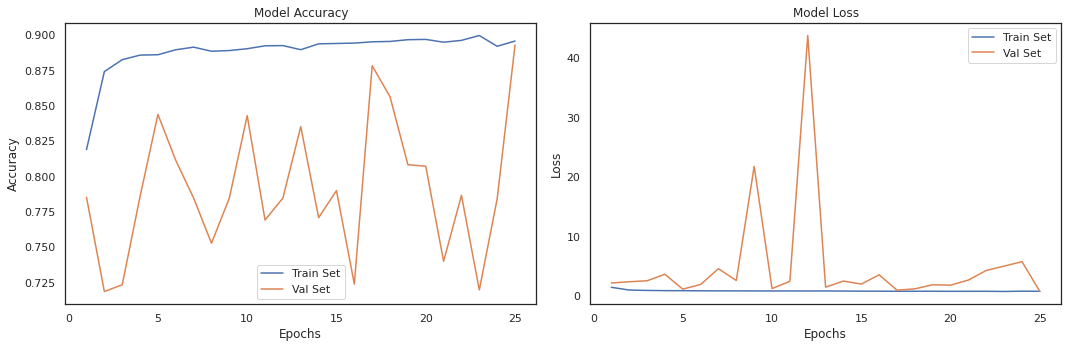

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [71]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 3662 validated image filenames.


In [77]:
STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
pred = model2.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
predictions = [np.argmax(pred) for pred in pred]

3662/3662 [==============================] - 397s 108ms/step


                      count      mean       std       min       25%       50%  \
0 - No DR               5.0  0.274946  0.393925  0.072539  0.094915  0.112112   
1 - Mild                5.0  0.211522  0.218732  0.014958  0.124352  0.152152   
2 - Moderate            5.0  0.501248  0.335585  0.006094  0.297297  0.718644   
3 - Severe              5.0  0.012284  0.019559  0.000000  0.000000  0.006780   
4 - Proliferative DR    5.0  0.000000  0.000000  0.000000  0.000000  0.000000   

                           75%       max  
0 - No DR             0.116216  0.978947  
1 - Mild              0.179661  0.586486  
2 - Moderate          0.727728  0.756477  
3 - Severe            0.008008  0.046632  
4 - Proliferative DR  0.000000  0.000000  


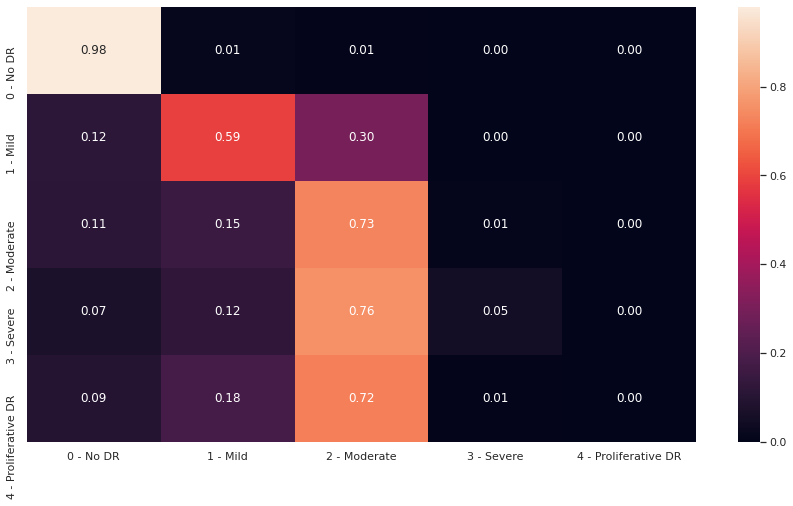

In [78]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), predictions)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
print(df_cm.describe().T)
plt.figure(figsize=(15, 8))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.show()

In [75]:
df_cm.head(5)

,0 - No DR,1 - Mild,2 - Moderate,3 - Severe,4 - Proliferative DR
0 - No DR,0.978947,0.014958,0.006094,0.000000,0.0
1 - Mild,0.116216,0.586486,0.297297,0.000000,0.0
2 - Moderate,0.112112,0.152152,0.727728,0.008008,0.0
3 - Severe,0.072539,0.124352,0.756477,0.046632,0.0
4 - Proliferative DR,0.094915,0.179661,0.718644,0.006780,0.0


In [79]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(predictions, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.692


In [80]:
print(classification_report(train['diagnosis'].astype('int'), predictions))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1805
           1       0.46      0.59      0.51       370
           2       0.60      0.73      0.66       999
           3       0.47      0.05      0.08       193
           4       0.00      0.00      0.00       295

    accuracy                           0.74      3662
   macro avg       0.49      0.47      0.44      3662
weighted avg       0.68      0.74      0.70      3662



In [94]:
import tensorflow
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

def f1_score_macro():
    return tfa.metrics.F1Score(num_classes = 5, average = 'macro', name = 'f1_score_macro', threshold = 0.5)

def f1_score_micro():
    return tfa.metrics.F1Score(num_classes = 5, average = 'micro', name = 'f1_score_micro', threshold = 0.5)


model = tensorflow.keras.models.load_model('./ResNet50.h5',# './model_cam_eq_adam_now.h5',
               custom_objects={ 'f1_score': F1Score,
                               
                              }
        )

TypeError: missing a required argument: 'num_classes'

In [92]:
model.save("New ResNet model.h5")

In [93]:
model = load_model("./New ResNet model.h5")

ValueError: Unknown metric function: f1_score